In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
traject = pd.read_csv('vehicle-trajectory-data/0750am-0805am/trajectories-0750am-0805am.csv')

In [3]:
traject # show the dataset

,Vehicle_ID,Frame_ID,Total_Frames,Global_Time,Local_X,Local_Y,Global_X,Global_Y,v_Length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID,Preceeding,Following,Space_Hdwy,Time_Hdwy
0,2,13,437,1118846980200,16.467,35.381,6451137.641,1873344.962,14.5,4.9,2,40.00,0.00,2,0,0,0.00,0.00
1,2,14,437,1118846980300,16.447,39.381,6451140.329,1873342.000,14.5,4.9,2,40.00,0.00,2,0,0,0.00,0.00
2,2,15,437,1118846980400,16.426,43.381,6451143.018,1873339.038,14.5,4.9,2,40.00,0.00,2,0,0,0.00,0.00
3,2,16,437,1118846980500,16.405,47.380,6451145.706,1873336.077,14.5,4.9,2,40.00,0.00,2,0,0,0.00,0.00
4,2,17,437,1118846980600,16.385,51.381,6451148.395,1873333.115,14.5,4.9,2,40.00,0.00,2,0,0,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,2783,8698,760,1118847848700,55.108,1901.744,6452497.662,1872062.617,17.5,5.4,2,35.64,-3.67,5,2775,2808,51.11,1.43
1048571,2783,8699,760,1118847848800,55.032,1905.296,6452500.375,1872060.416,17.5,5.4,2,35.33,-3.67,5,2775,2808,51.26,1.45
1048572,2783,8700,760,1118847848900,55.044,1908.787,6452503.036,1872058.143,17.5,5.4,2,35.09,-0.48,5,2775,2808,51.49,1.47
1048573,2783,8701,760,1118847849000,55.133,1912.289,6452505.651,1872055.808,17.5,5.4,2,35.05,0.00,5,2775,2808,51.71,1.48


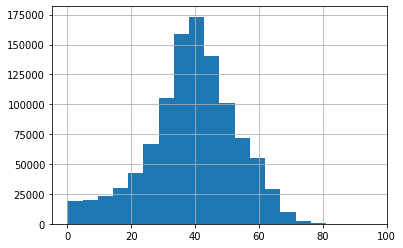

In [4]:
# investigate lengths and velocity of cars

# traject.v_Length.hist(bins=20)
traject.v_Vel.hist(bins=20)

In [5]:
# count number of cars showed up during this 15 mins period

traject.Vehicle_ID.nunique()

1993

Average is  0.4062248995983936
Median is  0.3


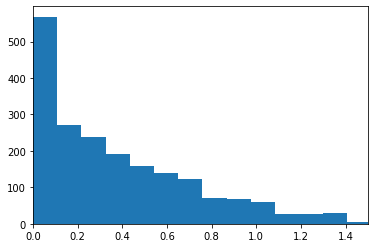

In [6]:
# find the time intervals between every two car-entries (presumably an exponential distribution); in unit of second
# this time interval will be used for simulation

subq = traject.groupby('Vehicle_ID').min() # find the entry time of each car

car_entry_time = subq.sort_values('Global_Time').Global_Time

car_entry_time = np.array(car_entry_time)

interval_bwt_cars = np.zeros((len(car_entry_time)-1,1))

for i in range(len(car_entry_time)-1):
    interval_bwt_cars[i] = (car_entry_time[i+1] - car_entry_time[i])/1000 # converted to seconds by dividing 1000

plt.hist(interval_bwt_cars,bins = 60) 
plt.xlim([0,1.5])

print('Average is ',np.mean(interval_bwt_cars))
print('Median is ', np.median(interval_bwt_cars))

# plt.savefig('Time_distribution.png',dpi=2000)

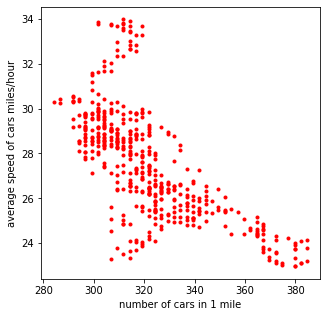

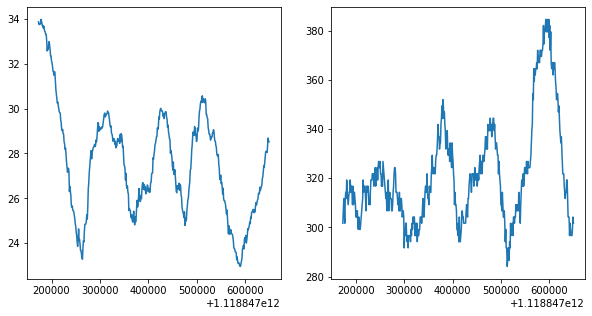

In [7]:
# finding the functional relationship between x = number of cars on road and y = average speed

# The total length of the road is 2100 feet.


# truncation of the raw dataset
traject_m = traject.sort_values('Global_Time')

traject_m = traject_m[200000:800000]

# compute the average speed and number of cars for each second
avg_speed = traject_m.groupby(np.floor(traject_m.Global_Time/1000.0/1)*1000*1).mean().v_Vel # in unit of feet/second
avg_speed = avg_speed * 0.681818 # to miles per hour

# line below finds number of cars on the 2100 feet road

num_of_cars_p = traject_m.groupby(np.floor(traject_m.Global_Time/1000.0/1)*1000*10).Vehicle_ID.nunique() # for later computation
# num_of_cars_p /= 10

num_of_cars = traject_m.groupby(np.floor(traject_m.Global_Time/1000.0/1)*1000*1).Vehicle_ID.nunique()

num_of_cars = num_of_cars / 2100 * 5280 # conversion of # of cars.
# divided by the length of the road, thus becomes # of cars per ft. Times 5280 to per mile.


v_vs_num = pd.merge(avg_speed,num_of_cars,how='inner',left_on='Global_Time',right_on='Global_Time')

# modified_average = v_vs_num.groupby(v_vs_num.Vehicle_ID).median()

# visualization
plt.figure(figsize = (5,5))
plt.plot(v_vs_num.Vehicle_ID,v_vs_num.v_Vel,'.r')
plt.xlabel('number of cars in 1 mile')
plt.ylabel('average speed of cars miles/hour')

plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.plot(avg_speed)
plt.subplot(1,2,2)
plt.plot(num_of_cars)

In [8]:
# fit a regression line to the data.

x = np.array(num_of_cars)
y = np.array(avg_speed)

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

print('Coefficients are ',slope, intercept)

print('p value is ', p_value) # check p values.

Coefficients are  -0.07924458143779052 53.03599730601424
p value is  6.440996384838783e-68


['The esitmated R^2 is', -0.6866619564248262]


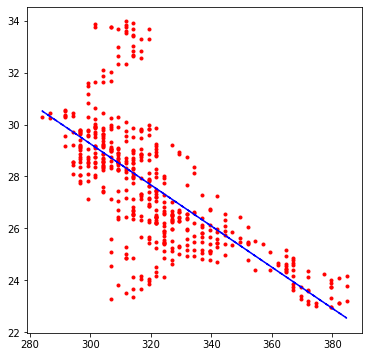

In [9]:
# visualization of fitted line

plt.figure(figsize = (6,6))

plt.plot(x,y,'.r')

plt.plot(x,slope * x + intercept,'--b')

print (['The esitmated R^2 is', r_value])

# plt.savefig('functional relationship.png',dpi=2000)

126.0

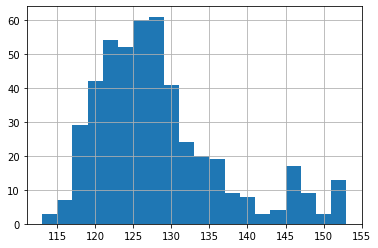

In [10]:
# number of cars on road
num_of_cars_p.hist(bins=20)
num_of_cars_p.to_csv(r'number_of_cars',index=False,header=False)

num_of_cars_p.median()

In [ ]:
all_ids = traject.Vehicle_ID.unique();

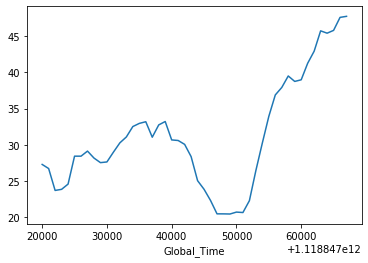

In [72]:
# investigate speed variation of an individual car

avg_speed = traject[traject.Vehicle_ID == 180].groupby(np.floor(traject.Global_Time/1000.0/1)*1000*1).mean().v_Vel
avg_speed = avg_speed * 0.681818 # to miles per hour

avg_speed.plot()

avg_speed.to_csv(r'average_speed_validation',index=False,header=False)

50.3

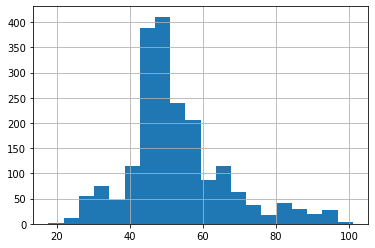

In [52]:
#

travel_time = traject.groupby([np.floor(traject.Global_Time/1000.0/1)*1000*1,traject.Vehicle_ID]).size() \
.groupby('Vehicle_ID').sum()

travel_time /= 10

# travel_time = traject[traject.Vehicle_ID == 2].groupby(np.floor(traject.Global_Time/1000.0/1)*1000*1).size()

travel_time.hist(bins=20)
travel_time.median()

# travel_time.to_csv(r'travel_time',index=False,header=False)

In [13]:
df = pd.read_csv('detector-data/detector-data.csv')

In [14]:
df

,Station,Date,Local_Time,Global_Time,V1,Occ1,Sp1,V2,Occ2,Sp2,...,Sp3,V4,Occ4,Sp4,V5,Occ5,Sp5,V_avg,Occ_avg,Sp_avg
0,717486,6/8/2005,0:00,1118214000000,0.0,0.0000,76.5,14.0,0.0052,74.0,...,82.0,89.0,0.0381,79.2,54.0,0.0275,74.5,213.0,0.0181,78.4
1,717486,6/8/2005,0:05,1118214300000,2.0,0.0008,76.9,20.0,0.0078,77.4,...,81.6,83.0,0.0502,74.4,53.0,0.0304,71.8,215.0,0.0226,76.0
2,717486,6/8/2005,0:10,1118214600000,2.0,0.0008,77.3,17.0,0.0082,76.9,...,78.0,67.0,0.0503,66.3,35.0,0.0217,69.0,168.0,0.0206,71.4
3,717486,6/8/2005,0:15,1118214900000,0.0,0.0000,77.3,23.0,0.0098,78.6,...,76.6,80.0,0.0449,70.9,40.0,0.0252,66.5,190.0,0.0203,72.3
4,717486,6/8/2005,0:20,1118215200000,17.0,0.0074,78.0,33.0,0.0156,75.1,...,68.2,29.0,0.0204,66.5,18.0,0.0125,60.6,129.0,0.0147,69.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15835,717490,6/22/2005,23:35,1119508500000,NaN,0.0063,80.2,NaN,0.0265,70.9,...,63.6,NaN,0.0748,49.0,NaN,0.0669,46.8,NaN,0.0421,58.3
15836,717490,6/22/2005,23:40,1119508800000,NaN,0.0087,79.7,NaN,0.0205,73.7,...,65.4,NaN,0.0434,56.4,NaN,0.0557,48.3,NaN,0.0332,62.0
15837,717490,6/22/2005,23:45,1119509100000,NaN,0.0053,81.6,NaN,0.0208,75.7,...,67.4,NaN,0.0430,63.5,NaN,0.0542,50.0,NaN,0.0313,65.1
15838,717490,6/22/2005,23:50,1119509400000,NaN,0.0047,80.9,NaN,0.0143,76.7,...,68.4,NaN,0.0376,66.6,NaN,0.0506,50.2,NaN,0.0285,65.6


In [15]:
(df.Global_Time[1] - df.Global_Time[0])/5/60 # 1s corresponds to 1000 units of Global_Time

1000.0

In [16]:
Sp1 = df[df.Date == '6/10/2005'].groupby(['Local_Time']).median().Sp1
V1 = df[df.Date == '6/10/2005'].groupby(['Local_Time']).median().V1
Occ1 = df[df.Date == '6/10/2005'].groupby(['Local_Time']).median().Occ1

In [17]:
df.Station.unique()

array([717486, 764766, 717488, 717489, 717490])

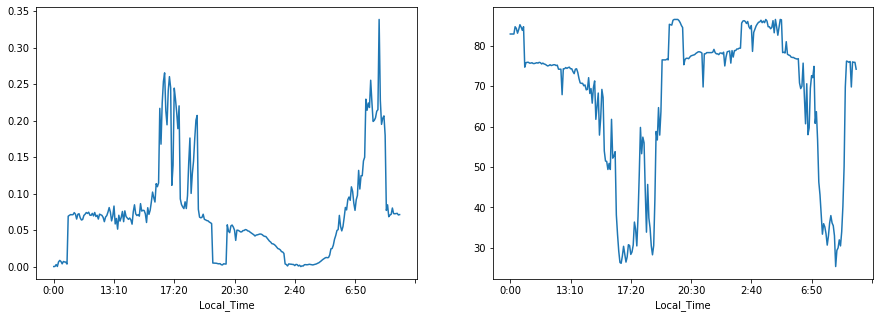

In [18]:
# Sp1.plot()
# V1.plot()
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
Occ1.plot()
plt.subplot(1,2,2)
Sp1.plot()

In [19]:
np.size(Occ1)
# np.size(Sp1)

288

(25.4, 86.5)

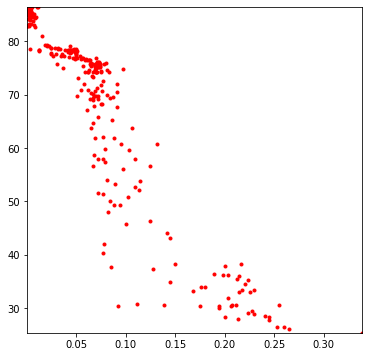

In [20]:
plt.figure(figsize = (6,6))

plt.plot(Occ1,Sp1,'.r')

plt.xlim(np.min(Occ1),np.max(Occ1))
plt.ylim(np.min(Sp1),np.max(Sp1))

In [21]:
x = np.array(Occ1) 
y = np.array(Sp1)

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

print(slope, intercept)

print(p_value)


-252.01957921741572 86.5881132287706
1.8505953047120196e-120


['The esitmated R^2 is', -0.9227644607730754]


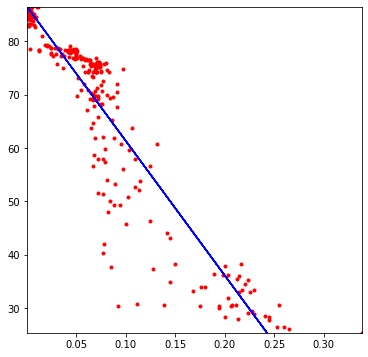

In [22]:

plt.figure(figsize = (6,6))

plt.plot(Occ1,Sp1,'.r')

plt.plot(Occ1,slope * Occ1 + intercept,'-b')

plt.xlim(np.min(Occ1),np.max(Occ1))
plt.ylim(np.min(Sp1),np.max(Sp1))

print (['The esitmated R^2 is', r_value])
